In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from aerio.BoundingBoxCollection import BoundingBoxCollection
from aerio.Photo import Photo

In [2]:
# During development, autoreload modules
%load_ext autoreload
%autoreload 2

# Masking labels
Many aerial photos contain labels and other text that can interfere with aerial triangulation. `aerio` has tools that can turn bounding boxes around labels into masks.

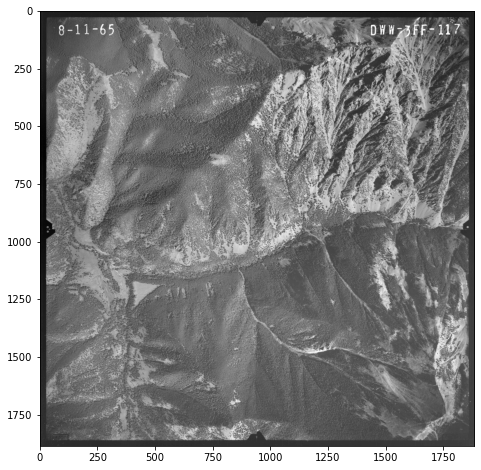

In [3]:
photo_path = os.path.join('data', 'DWW_3FF_117.tif')
photo = Photo(photo_path, photo_size=(224, 224))
# Note the labels in the upper left and upper right corners. We want to mask these.
photo.preview()

## Manual masking of labels
`aerio` generates masks from bounding boxes, so we first need to identify bounding boxes around the labels. This can be done manually by creating lists of pixel coordinates around labels. This may be feasible if the labels are in the same location in every image.

### Locating labels

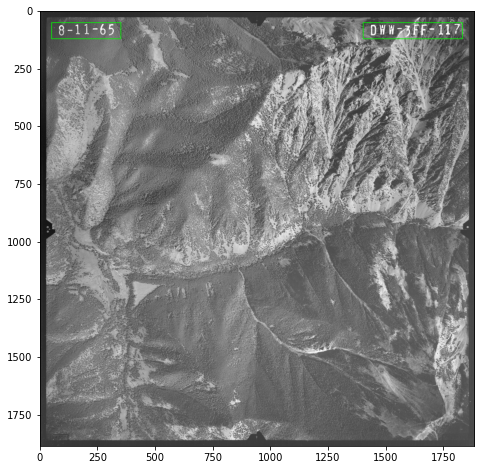

In [4]:
# Boxes can be manually created as a list of pixel coordinates. Coordinates can be 
# entered clockwise or counterclockwise.
upper_left = [[50, 50], [350, 50], [350, 120], [50, 120]]
upper_right = [[1400, 50], [1830, 50], [1830, 120], [1400, 120]]

boxes = BoundingBoxCollection([upper_left, upper_right], photo)
    
boxes.preview()

## Automatic masking of labels
There are many techniques for automatically locating text within images. In this example, we will use the `swtloc` library to generate bounding boxes around text.

### Locating labels

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



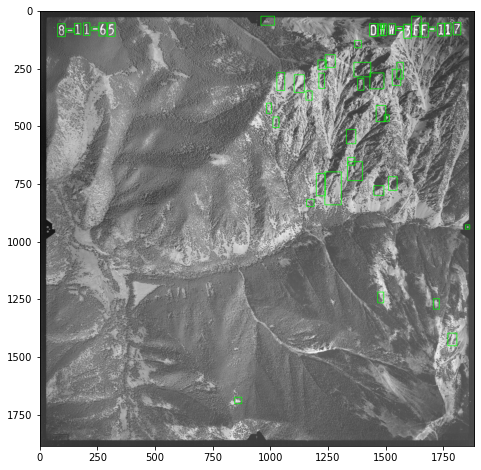

In [6]:
from swtloc import SWTLocalizer
swtl = SWTLocalizer()

swtl.swttransform(imgpaths=photo_path, save_results=False,
                  edge_func = 'ac', ac_sigma = 0.4, text_mode = 'db_lf',
                  gs_blurr=True, blurr_kernel = (15, 15), 
                  minrsw = 5, maxrsw = 15,
                  minCC_comppx = 50, maxCC_comppx = 1000,  
                  max_angledev = np.pi/6,
                  acceptCC_aspectratio = 5.)

bbox, _ = swtl.get_extreme_bbox(show=False)

# Turn the lists of coordinates into Bounding Box objects
labels = BoundingBoxCollection(bbox, photo)
# Preview the un-processed bounding boxes. Note the large number of false positive boxes.
labels.preview(color=(0, 255, 0))

### Cleaning up labels
Automated detection of label bounding boxes may result in many false positives, depending on the SWT parameters, the image, and the labels. The `aerio` library has tools for cleaning bounding boxes prior to generating masks.

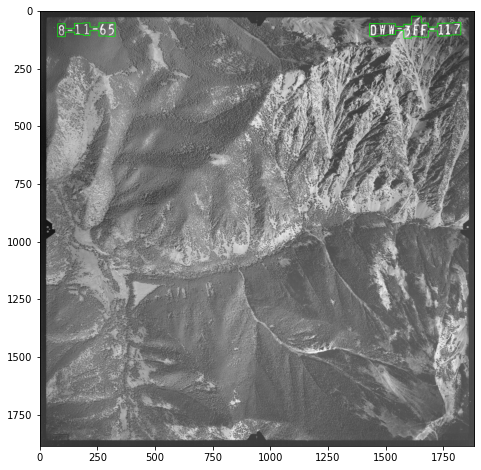

In [7]:
# Collapse nearby bounding boxes to merge characters. An asymetrical kernel helps to
# connect horizontally adjacent characters.
labels.collapse(kernel=np.ones((5, 15), np.uint8), iterations=20)

# Filter for boxes near the edge of the image that are wider than tall.
labels.filter(max_edge_distance = 100, max_hw_ratio=0.5)

labels.preview(color=(0, 255, 0))

## Locating photo borders
Aerial photo margins often contain borders that can interfere with aerial triangulation. `aerio` can automatically generate bounding boxes around photo borders. This will only work if the borders are relatively straight and centered.

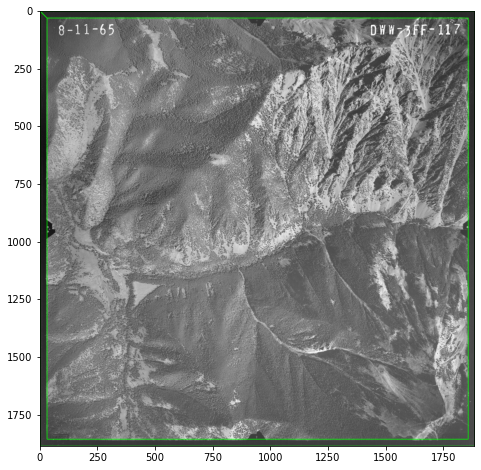

In [10]:
border = photo.border_box(30)

borders = BoundingBoxCollection([border], photo)
borders.preview()

## Combining boxes
Additional boxes can be added to a BoundingBoxCollection by adding a list of coordinates or adding the boxes from another collection. This can be used, for example, to combine label boxes and border boxes into a single collection that can be masked

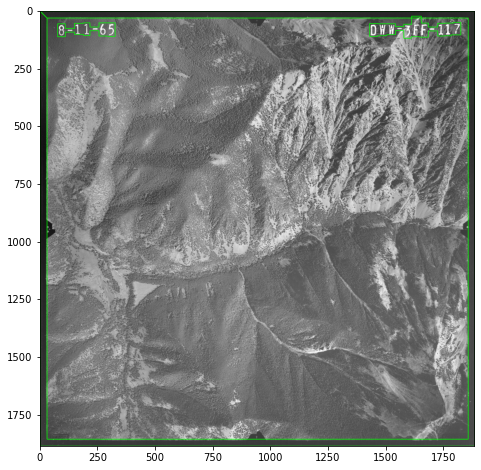

In [11]:
combined = borders + labels

combined.preview()

## Generating masks from boxes
Bounding box collections can be converted into raster masks.

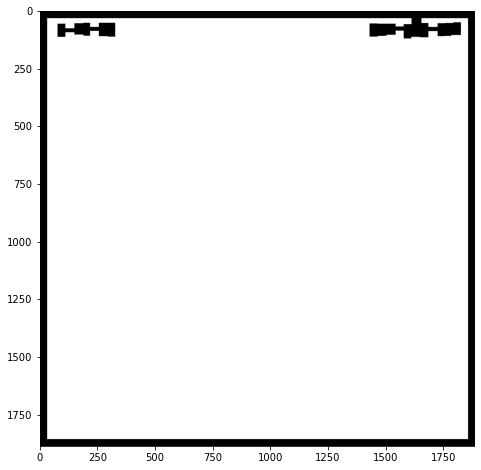

In [12]:
mask = combined.generate_mask()

_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mask, cmap="gray")